In [ ]:
## Load required packages
#cool test
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime

In [ ]:
## define directory
dir_path = os.path.abspath('')
os.chdir('..')
from pyCiSSA.pycissa import cissa, group, cissa_outlier, build_groupings

In [ ]:
## Read data file  (source is the Ministry of Economy of Spain.)
data = pd.read_excel(dir_path + r'/Hopelands_Data_20221106.xlsx')
print(data.head(5))
print(data.npID.unique())

                     sID  npID          SampleDate Value
0  Manawatu at Hopelands  NH4N 1989-09-27 10:33:00  0.01
1  Manawatu at Hopelands   DRP 1989-09-27 10:33:00  0.02
2  Manawatu at Hopelands   NO3 1989-09-27 10:33:00  1.15
3  Manawatu at Hopelands  CLAR 1989-09-27 10:33:00   0.8
4  Manawatu at Hopelands  NH4N 1989-10-11 10:20:00  0.04
['NH4N' 'DRP' 'NO3' 'CLAR' 'ECOLI' 'DO_Conc' 'SSC' 'MCI' 'ASPM' 'QMCI'
 'Chl_a' 'Dep_Sed' 'SIN']


In [ ]:
## Choose parameter of interest
variable = 'DRP'
filtered_data = data.loc[data['npID'] == variable].reset_index(drop=True)
print(filtered_data.head(5))

                     sID npID          SampleDate  Value
0  Manawatu at Hopelands  DRP 1989-09-27 10:33:00   0.02
1  Manawatu at Hopelands  DRP 1989-10-11 10:20:00  0.011
2  Manawatu at Hopelands  DRP 1989-11-22 09:34:00  0.012
3  Manawatu at Hopelands  DRP 1989-12-13 09:45:00  0.013
4  Manawatu at Hopelands  DRP 1990-01-24 09:40:00  0.005


In [ ]:
## fix the censored values
def remove_censoring(df,valuecolumn = 'Value', strings_to_replace = ['<','>']):
    '''
    Function to take a pandas dataframe and remove unwanted strings from the column.
    Useful for removing censoring...

    Parameters
    ----------
    df : pandas dataframe
        DESCRIPTION: Input pandas dataframe which contains column to remove strings from
    valuecolumn : string, optional
        DESCRIPTION: The default is 'value'. Column name in the dataframe which we want to remove the defined strings from
    strings_to_replace :  list, optional
        DESCRIPTION: The default is '['<','>']'. List of strings which we want to remove from the data

    Returns
    -------
    df : pandas dataframe
        DESCRIPTION: Output pandas dataframe which contains a new column with the strings of interest removed
    '''


    #check valuecolumn is in the dataframe columns
    if not valuecolumn in list(df.columns):
        raise Exception(f'Column: {valuecolumn} not found in this dataframe')

    new_column = []
    #Iterate through dataframe values
    for value_n in df[valuecolumn]:
        string = ''
        #make value a string
        string = str(value_n)

        #replace unwanted characters
        for str_i in strings_to_replace:
            string = string.replace(str_i, '')

        try: #try to append float value
            new_column.append(float(string))
        except: #if making float fails, just append the original value
            new_column.append(value_n)

    #Add new column to dataframe
    df['uncensored_value'] =   new_column
    return df



uncensored_data = remove_censoring(filtered_data)


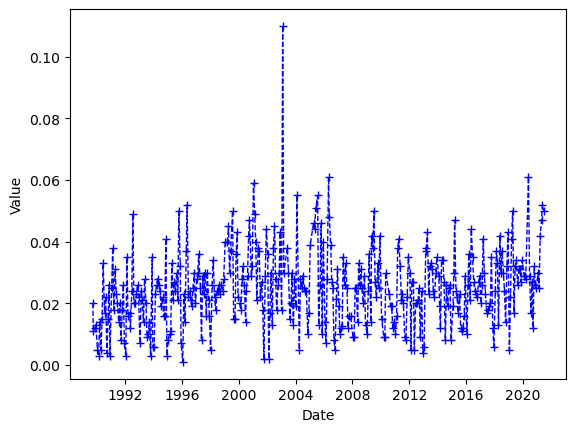

In [ ]:
## Plot the data
plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--+', lw=1.0)
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

In [ ]:
## Add in year and month
uncensored_data['year'] = uncensored_data['SampleDate'].dt.year
uncensored_data['month'] = uncensored_data['SampleDate'].dt.month
uncensored_data.head()

,sID,npID,SampleDate,Value,uncensored_value,year,month
0,Manawatu at Hopelands,DRP,1989-09-27 10:33:00,0.02,0.020,1989,9
1,Manawatu at Hopelands,DRP,1989-10-11 10:20:00,0.011,0.011,1989,10
2,Manawatu at Hopelands,DRP,1989-11-22 09:34:00,0.012,0.012,1989,11
3,Manawatu at Hopelands,DRP,1989-12-13 09:45:00,0.013,0.013,1989,12
4,Manawatu at Hopelands,DRP,1990-01-24 09:40:00,0.005,0.005,1990,1


In [ ]:
## Minimum year, month
min_year = uncensored_data['year'].min()
min_month = uncensored_data.loc[uncensored_data['year'] == min_year]['month'].min()

max_year = 2021
max_month = uncensored_data.loc[uncensored_data['year'] == max_year]['month'].max()

print(min_month,min_year)
print(max_month,max_year)

9 1989
6 2021


In [ ]:
## Replace missing values
missing_value = -1

data_with_missing_replaced = pd.DataFrame(columns = ['date', 'value', 'missing'])

for year_i in range(min_year,max_year+1):
    start_month = 1
    end_month = 12
    if year_i == min_year:
        start_month = min_month
    if year_i == max_year:
        end_month = max_month

    for month_i in range(start_month,end_month+1):
        temp_row,temp_date = None,None
        temp_date = datetime.datetime(year_i, month_i, 15)
        temp_row = uncensored_data.loc[(uncensored_data['year'] == year_i) & (uncensored_data['month'] == month_i)]

        if len(temp_row) == 0:
            data_with_missing_replaced.loc[len(data_with_missing_replaced)] = [temp_date,missing_value,1]
        else:
            data_with_missing_replaced.loc[len(data_with_missing_replaced)] = [temp_date,np.median(temp_row['uncensored_value']),0]

data_with_missing_replaced.head()

print(f'Percent of missing values = {100*len(data_with_missing_replaced.loc[data_with_missing_replaced["missing"] == 1])/len(data_with_missing_replaced)}')


Percent of missing values = 2.8795811518324608


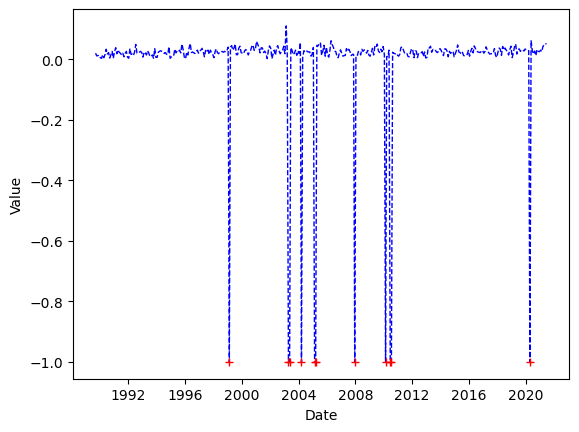

In [ ]:
## Missing rows only
missing_rows = data_with_missing_replaced.loc[data_with_missing_replaced['missing'] == 1]
x = list(missing_rows.index)

## Plot the data including missing values
plt.plot(data_with_missing_replaced['date'], data_with_missing_replaced['value'], 'b--', lw=1.0)
plt.plot(missing_rows['date'], missing_rows['value'], 'r+', lw=1.0)
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

In [ ]:
#CiSSA parameters
L = 12*8
data_per_year = 12

## Define error correction parameters
outliers = ['<',0]  #any value < -1 is an outlier/missing value
errors = ['value', 0.02]  #converge until error < 50
eigenvalue_proportion = 0.98

In [ ]:
## Apply cissa_outliers to check the reconstricted signal
## run pyCiSSA with outliers
x_ca, x_casa, rc = cissa_outlier(data_with_missing_replaced['value'],L,data_per_year,data_per_year,outliers = outliers,errors = errors, eigenvalue_proportion = eigenvalue_proportion)

Initial guess for outliers: [0.024 0.024 0.024 0.024 0.024 0.024 0.024 0.024 0.024 0.024 0.024]
New points: [0.02307229 0.0217757  0.02553155 0.02658781 0.02505701 0.02301556
 0.02269847 0.02123502 0.02299913 0.02450905 0.02507775]
Consecutive prediction error: 0.0027649802193856557 vs target error: 0.02
iteration: 2, error: 1.0265878071359964 vs target error: 0.02
Initial guess for outliers: []
iteration: 0, error: 0.0 vs target error: 0.02


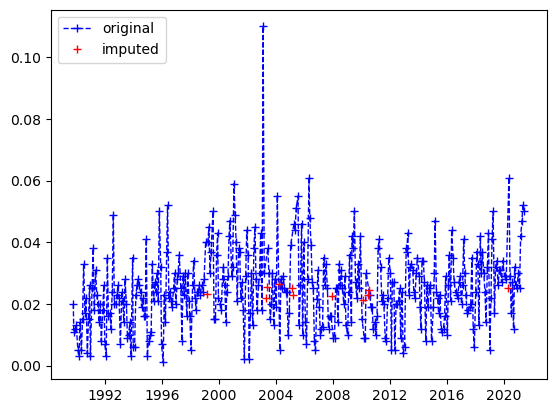

In [ ]:

#plt.plot(data_with_missing_replaced['date'], data_with_missing_replaced['value'], 'b', lw=1.0, label = 'original')
plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--+', lw=1.0, label = 'original')
plt.plot(data_with_missing_replaced.loc[x,'date'], x_ca[x], 'r+', lw=1.0, label = 'imputed')
plt.legend(loc="upper left")

In [ ]:
## Build grouping cell
Z,psd = cissa(x_ca,L)
period_ranges = {}
period_ranges.update({'long term cycle': [4,8]})
period_ranges.update({'seasonality': [0.9,1.1]})
I  = build_groupings(period_ranges,data_per_year,psd,Z,include_noise = True)
#2) Group components
rc, sh, kg = group(Z,psd,I)
print(sh)
print(kg)

{'long term cycle': 7.0838396407648485, 'seasonality': 9.267462153210495, 'trend': 5.590656316160689, 'noise': 77.71345586496791}
{'long term cycle': array([1, 2]), 'seasonality': array([7, 8]), 'trend': array([0]), 'noise': array([ 3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47])}


dict_keys(['long term cycle', 'seasonality', 'trend', 'noise'])


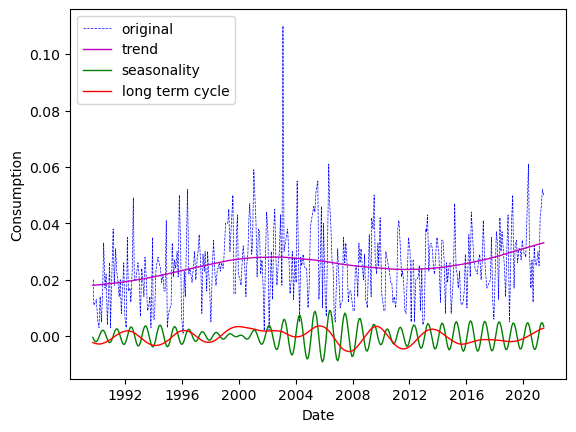

In [ ]:
##plot trend, seasonality, long term cycle

print(rc.keys())

plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--', lw=0.5, label = 'original')
plt.plot(data_with_missing_replaced['date'], rc['trend'], 'm', lw=1.0, label = 'trend')
plt.plot(data_with_missing_replaced['date'], rc['seasonality'], 'g', lw=1.0, label = 'seasonality')
plt.plot(data_with_missing_replaced['date'], rc['long term cycle'], 'r', lw=1.0, label = 'long term cycle')
#plt.plot(data_with_missing_replaced['date'], rc['noise'], 'k', lw=1.0, label = 'noise')
plt.legend(loc="upper left")
plt.ylabel('Consumption')
plt.xlabel('Date')
plt.show()

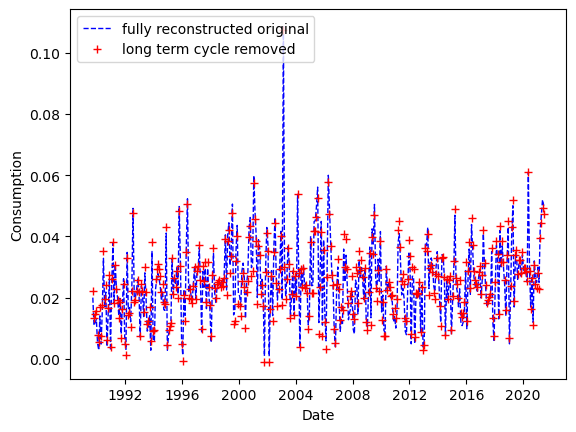

In [ ]:
##plot data without long term cycle
rc_all = np.zeros(rc['trend'].shape)
rc_reduced = rc_all.copy()
for rc_i in rc.keys():
    rc_all += rc.get(rc_i)
    if not rc_i == 'long term cycle':
        rc_reduced += rc.get(rc_i)

#plt.plot(uncensored_data['SampleDate'], uncensored_data['uncensored_value'], 'b--', lw=0.5, label = 'original')
plt.plot(data_with_missing_replaced['date'], rc_all, 'b--', lw=1.0, label = 'fully reconstructed original')
plt.plot(data_with_missing_replaced['date'], rc_reduced, 'r+', lw=1.0, label = 'long term cycle removed')
plt.legend(loc="upper left")
plt.ylabel('Consumption')
plt.xlabel('Date')
plt.show()


In [ ]:
sh

{'long term cycle': 7.0838396407648485,
 'seasonality': 9.267462153210495,
 'trend': 5.590656316160689,
 'noise': 77.71345586496791}